<a href="https://colab.research.google.com/github/thejameszhang/Netflix-IMBd-Score-Predicter/blob/main/sifapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importing the Python libraries

The objective of this model is to accurately predict the IMDb score of a show or movie based on quantitative data, such as Hidden Gem Score, Rotten Tomatoes Score, Metacritic Score, Boxoffice, and IMDb Votes. Textual data in the Tags and Languages column will be converted to numbers using one hot encoding using the pandas get_dummies function.



In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 2) Reading the Netflix Dataset

I deleted all of the following columns in the excel sheet because they served no purpose for my algorthm: Director, Writer, Actors, Release Date, Netflix Release Date, Production House, IMDb link, Image, Poster, IMDb Trailer, and Trailer Site

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

excel_file = "/content/drive/MyDrive/NetflixData.xlsx"
df = pd.read_excel(excel_file)

df.head()

Mounted at /content/drive


,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,View Rating,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,Summary,IMDb Votes
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,Thailand,< 30 minutes,R,7.9,98.0,82.0,74.0,57.0,2122065.0,A med student with a supernatural gift tries t...,205926.0
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,Canada,1-2 hour,R,5.8,79.0,69.0,1.0,NaN,70632.0,"When nerdy Johanna moves to London, things get...",2838.0
2,The Con-Heartist,"Comedy, Romance","Romantic Comedies,Comedies,Romantic Films,Thai...",Thai,Movie,8.6,Thailand,> 2 hrs,NaN,7.4,NaN,NaN,NaN,NaN,NaN,After her ex-boyfriend cons her out of a large...,131.0
3,Gleboka woda,Drama,"TV Dramas,Polish TV Shows,Social Issue TV Dramas",Polish,Series,8.7,Poland,< 30 minutes,,7.5,NaN,NaN,2.0,4.0,NaN,A group of social welfare workers led by their...,47.0
4,Only a Mother,Drama,"Social Issue Dramas,Dramas,Movies Based on Boo...",Swedish,Movie,8.3,"Lithuania,Poland,France,Italy,Spain,Greece,Bel...",1-2 hour,NaN,6.7,NaN,NaN,2.0,1.0,NaN,An unhappily married farm worker struggling to...,88.0


The pandas groupby function separates a column's data and calculates some statistic separately. For example, the first line of code calculates the mean IMDb Scores for series and movie, as can be seen in the output. Interestingly enough, there seems to be a significant difference, as Series generally rate higher on the IMDb scale.

In [ ]:
print(df.groupby("Series or Movie")["IMDb Score"].mean())
print()

print(df.groupby("View Rating")["IMDb Score"].mean())
print()

print(df.groupby("Runtime")["IMDb Score"].mean())
print() 

Series or Movie
Movie     6.752828
Series    7.543188
Name: IMDb Score, dtype: float64

View Rating
             7.500000
AL           7.400000
Approved     7.266667
E            7.300000
G            6.978409
GP           7.850000
M/PG         7.400000
MA-17        7.200000
NC-17        7.212500
NOT RATED    8.000000
Not Rated    6.958493
PG           6.509091
PG-13        6.465114
Passed       7.535714
R            6.627100
TV-13        7.600000
TV-14        7.452025
TV-G         7.227869
TV-MA        7.284698
TV-PG        7.479478
TV-Y         7.351136
TV-Y7        7.330882
TV-Y7-FV     7.713636
Unrated      6.670588
X            6.933333
Name: IMDb Score, dtype: float64

Runtime
1-2 hour        6.632262
30-60 mins      7.133088
< 30 minutes    7.525768
> 2 hrs         7.107687
Name: IMDb Score, dtype: float64



In [ ]:
new_df = df[["Hidden Gem Score", "Rotten Tomatoes Score", "Metacritic Score", "Boxoffice", "IMDb Votes", "IMDb Score"]]

#3) Data Analysis

Let's see a scatter plot of every feature plotted alonside every other feature, otherwise known as a scatter plot. As we can see, there are some clear, positive correlations.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffafc6d3d90>,
      dtype=object)

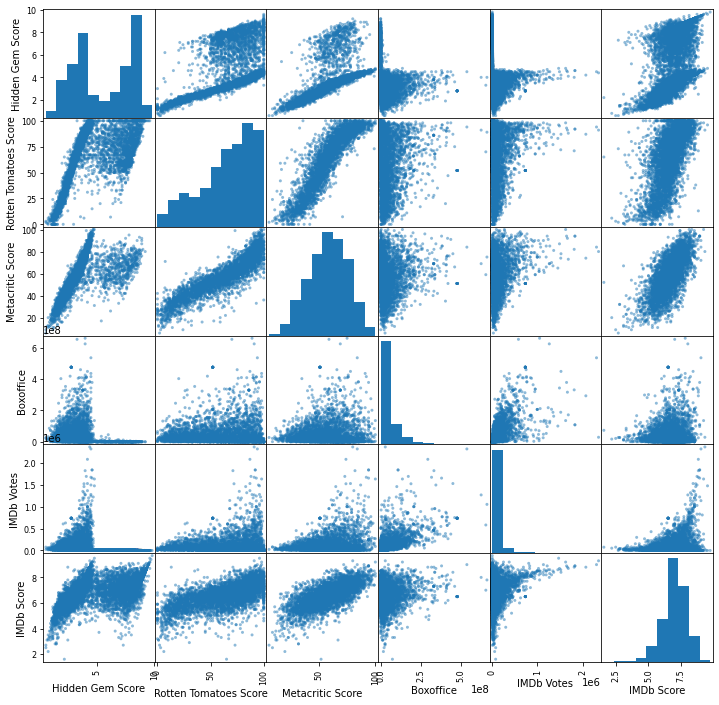

In [ ]:
scatter_matrix(new_df, figsize = (12,12))

This information can also be portrayed in a heatmap.

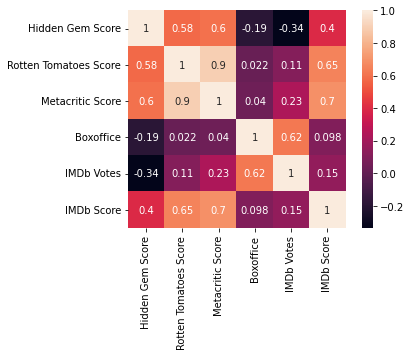

In [ ]:
sns.heatmap(new_df.corr(), square=True, annot=True)

Let's display some simple statistics for each feature.

In [ ]:
new_df.agg(
    {
      "Hidden Gem Score": ["min", "max", "mean", "median", "skew"],
      "IMDb Score": ["min", "max", "mean", "median", "skew"],
      "Rotten Tomatoes Score": ["min", "max", "mean", "median", "skew"],
      "Metacritic Score": ["min", "max", "mean", "median", "skew"],
      "Boxoffice": ["min", "max", "mean", "median", "skew"],
      "IMDb Votes": ["min", "max", "mean", "median", "skew"],
    }
)

,Hidden Gem Score,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Boxoffice,IMDb Votes
min,0.600000,1.600000,0.000000,6.000000,7.200000e+01,5.000000e+00
max,9.800000,9.700000,100.000000,100.000000,6.593639e+08,2.354197e+06
mean,5.540733,6.955517,64.679027,58.113425,4.845788e+07,6.014725e+04
median,5.300000,7.000000,70.000000,59.000000,2.250466e+07,6.602000e+03
skew,-0.038160,-0.645655,-0.651735,-0.172267,2.969226e+00,5.581542e+00


#One Hot Encoding

In order to change this categorical numbers to numerics, we don't want to just use a hashmap. Take the following example.

{"red": 0, "white": 1, "purple": 2}

This implies that red is closer to white than purple, which is not necessarily true. Instead, take the alternative.

{"red": (1, 0, 0), "white": (0, 1, 0), "purple": (0, 0, 1)}

This is known as one-hot encoding, and using these ordinal values is better because there are no issues with scaling. We will use this idea for both the tags and languages columns.

In [ ]:
tags = df["Tags"].str.get_dummies(",")
languages = df["Languages"].str.get_dummies(",")

for x in languages.columns:
  new_df[x] = languages[x]

for y in tags.columns:
  new_df[y] = tags[y]

print(new_df.shape)
new_df.head() #see the removed columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-

(9425, 1239)


,Hidden Gem Score,Rotten Tomatoes Score,Metacritic Score,Boxoffice,IMDb Votes,IMDb Score,Ancient (to 1453),Old,Aboriginal,Acholi,...,Zombie Horror Movies,コメディ,ヒューマンドラマ,ラブロマンス,ロマンチックなヒューマンドラマ,ロマンチックコメディ,海外コメディ,海外ヒューマンドラマ,海外ラブロマンス,海外映画
0,4.3,98.0,82.0,2122065.0,205926.0,7.9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.0,79.0,69.0,70632.0,2838.0,5.8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8.6,NaN,NaN,NaN,131.0,7.4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.7,NaN,NaN,NaN,47.0,7.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.3,NaN,NaN,NaN,88.0,6.7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#3) Data Cleaning / Preprocessing

The pandas function pd.isna(var) returns if var is NaN. The .index notation returns an entire sub list of all of the indexes that satisfy the condition inside the df[]. Therefore, this line of code below is the entire sublist of NaN values in the entire "Metacritic Score" column. 

In [ ]:
(new_df[pd.isna(df["Metacritic Score"])]).index

Int64Index([   2,    3,    4,    5,    7,    8,   12,   13,   14,   15,
            ...
            9402, 9403, 9405, 9406, 9407, 9409, 9417, 9422, 9423, 9424],
           dtype='int64', length=5343)

We want to get rid of all of the empty, default values in the dataset such that every Netflix show/movie contains all of its data. Looping through the entire pandas dataframe, go column by column, and remove every row containing an NaN value returned by the above line of code. A row is removed by using the pandas drop method. Axis="index" just specifies to delete the entire row, not the column.

In [ ]:
new_df.fillna(0, inplace=True)

As you can see, we started with over 9,400 rows, and now we only have 3,219, so even though we've made our training and testing sets smaller, the data is cleaner.

In [ ]:
display(new_df)

,Hidden Gem Score,Rotten Tomatoes Score,Metacritic Score,Boxoffice,IMDb Votes,IMDb Score,Ancient (to 1453),Old,Aboriginal,Acholi,...,Zombie Horror Movies,コメディ,ヒューマンドラマ,ラブロマンス,ロマンチックなヒューマンドラマ,ロマンチックコメディ,海外コメディ,海外ヒューマンドラマ,海外ラブロマンス,海外映画
0,4.3,98.0,82.0,2122065.0,205926.0,7.9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.0,79.0,69.0,70632.0,2838.0,5.8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8.6,0.0,0.0,0.0,131.0,7.4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.7,0.0,0.0,0.0,47.0,7.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.3,0.0,0.0,0.0,88.0,6.7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9420,3.1,65.0,57.0,57231747.0,167842.0,6.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9421,8.2,89.0,65.0,0.0,878.0,6.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9422,8.6,0.0,0.0,0.0,14.0,7.3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9423,8.8,0.0,0.0,0.0,174.0,7.8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#4) Creating the Linear Regression Model

Here, we're just separating the pandas dataframe into input and output numpy arrays.

In [ ]:
Y = np.asarray(new_df["IMDb Score"])
X = np.asarray(new_df[["Hidden Gem Score", "Rotten Tomatoes Score", "Metacritic Score", "Boxoffice", "IMDb Votes"]])

Using the train_test_split sklearn function, split the input and output lists into training and testing lists.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", Y_test.shape)

X_train:  (7068, 5)
Y_train:  (7068,)
X_test:  (2357, 5)
Y_test:  (2357,)


Here we're actually creating, training, and testing the model.

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, Y_train)

RandomForestRegressor()

In [ ]:
result_df = pd.DataFrame({"Predicted": model.predict(X_test), "Actual": Y_test})

In [ ]:
#Mean Square Error
np.mean((result_df["Predicted"] - result_df["Actual"]) ** 2)

0.10494209713583555

In [ ]:
result_df.head()

,Predicted,Actual
0,6.487,6.6
1,6.964,7.0
2,6.471,6.5
3,7.905,8.0
4,6.192,6.0


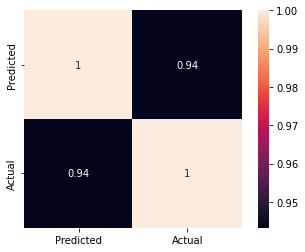

In [ ]:
sns.heatmap(result_df.corr(),square=True,annot=True)

Text(0, 0.5, 'Actual')

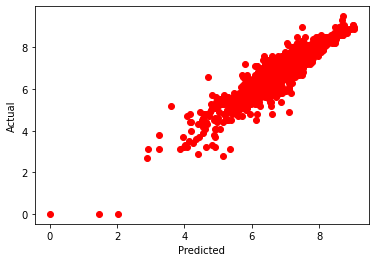

In [ ]:
plt.scatter(result_df["Predicted"], result_df["Actual"], color="red")
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
print("Accuracy:  " + str(model.score(X_test, Y_test)))

Accuracy:  0.8862769702012037
